# Premier jeu de données 

## Import des modules utiles

In [2]:

import numpy as np
import pandas as pd 
import os
import matplotlib.pyplot as plt
import igraph as ig

os.listdir() #lister les fichiers du répertoire local


['tétaploïde_avec_dosage.ipynb',
 'donnees_tétaploïde.nb.html',
 '.ipynb_checkpoints',
 'Rapport jeu de données 1.ipynb',
 'Rapport jeu de données 1.pdf',
 'README.txt',
 'donnees_tétaploïde.Rmd',
 'Brouillon_généalogie_rosier.ipynb',
 'Pop2_v2.ipynb',
 '.Rhistory',
 'Rapport jeu de données 2.pdf']

## Chargement des données 

In [3]:
path='/home/ibotcazou/Bureau/Master_data_science/DATAS_M2/Option Biologie/projet'

data = pd.read_csv(path+'/DataGeno2x.csv',header=None)

data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,10,10,0,0,50,60,0,0,100,100,0,0,140,140,0,0,1,1
1,10,20,0,0,60,70,0,0,110,110,0,0,150,160,0,0,1,2
2,30,30,0,0,60,70,0,0,130,130,0,0,150,160,0,0,1,3
3,10,40,0,0,80,90,0,0,140,140,0,0,150,150,0,0,1,4
4,10,20,0,0,60,60,0,0,100,110,0,0,140,160,0,0,2,5
5,10,20,0,0,70,90,0,0,110,140,0,0,150,150,0,0,2,6
6,10,10,0,0,60,60,0,0,100,110,0,0,140,160,0,0,3,7


Face à ce jeu de données, nous allons modifier son allure pour mieux en ressortir les informations qu'il contient. Nous savons que nous avons des individus sur chaque ligne, des rosiers en l'occurrence. La colonne '16' correspond à la génération du rosier. Les autres colonnes sont à considérer par 4 car sous un format tétaploïde. Dans ce premier jeu de données, les individus sont diploïdes. Il y a 4 marqueurs qui correspondent à des marqueurs moléculaires. Les valeurs dans le tableau représentent le nombre de nucléotides pour un marqueur moléculaire donné.   

##  Preprocessing

In [4]:
n = len(data)
car = 4 #nb de marqueurs
gen = 5 # on ne veut que pour les génération plus grande que 1 


# Définir la dernière colonne comme indice
data = data.set_index(data.columns[-1])

# Liste des noms de colonnes contenant que des zéros
colonnes_a_supprimer = [colonne for colonne in data.columns if (data[colonne] == 0).all()]

# Supprimez les colonnes contenant uniquement des zéros
data = data.drop(columns=colonnes_a_supprimer)

#donner un nom à la colonne index
data.index.name = 'index'


data

,0,1,4,5,8,9,12,13,16
index,,,,,,,,,
1,10,10,50,60,100,100,140,140,1
2,10,20,60,70,110,110,150,160,1
3,30,30,60,70,130,130,150,160,1
4,10,40,80,90,140,140,150,150,1
5,10,20,60,60,100,110,140,160,2
6,10,20,70,90,110,140,150,150,2
7,10,10,60,60,100,110,140,160,3


In [5]:
# Créez un dictionnaire de correspondance des noms de colonnes
nouveaux_noms = {0:'marqueur_1.0',1:'marqueur_1.1',
                 4:'marqueur_2.0',5:'marqueur_2.1',
                 8:'marqueur_3.0',9:'marqueur_3.1',
                 12:'marqueur_4.0',13:'marqueur_4.1',
                16:'generation'}

#Remplacer les noms de colonnes pour se faciliter le travail 

data.rename(columns= nouveaux_noms, inplace=True)

data


,marqueur_1.0,marqueur_1.1,marqueur_2.0,marqueur_2.1,marqueur_3.0,marqueur_3.1,marqueur_4.0,marqueur_4.1,generation
index,,,,,,,,,
1,10,10,50,60,100,100,140,140,1
2,10,20,60,70,110,110,150,160,1
3,30,30,60,70,130,130,150,160,1
4,10,40,80,90,140,140,150,150,1
5,10,20,60,60,100,110,140,160,2
6,10,20,70,90,110,140,150,150,2
7,10,10,60,60,100,110,140,160,3


## Programmation

### Fonction 1 

In [6]:
# Générer les enfants virtuels à l'aide de deux parents pour un marqueur donné

def generEnf_Enf(P1,P2,m): 
    #P1 et P2 sont des int associés à l'indice des parents
    #m est est un entier compris entre 1 et 4 car il y a 4 caractéristiques
    
    P1_a,P1_b =data.loc[P1,[f'marqueur_{m}.0',f'marqueur_{m}.1']] 
    #permet de stocker les allèles du parent 1 sur le marqueur m
    
    P2_a,P2_b =data.loc[P2,[f'marqueur_{m}.0',f'marqueur_{m}.1']] 
    #permet de stocker les allèles du parent 2 sur le marqueur m
    return np.array([[P1_a,P2_a],[P1_a,P2_b],[P1_b,P2_a],[P1_b,P2_b]])

generEnf_Enf(1,2,1) 
#exemple pour les parents 1 et 2 et le marqueur 1 

array([[10, 10],
       [10, 20],
       [10, 10],
       [10, 20]])

### Fonction 2

In [7]:
# donner pour un marqueur donné et une liste d'enfants virtuels pour un couple de parent
#le nombre  de fois ou l'enfant réel apparaît.


def compteEnf_virt_reel(P1,P2,E,m): 
    #m est est un entier compris entre 1 et 4 
    # E est un entier pour une ligne donnée 
    
    E_virt = generEnf_Enf(P1,P2,m)
    #liste des enfants virtuels
    
    E_a,E_b =data.loc[E,[f'marqueur_{m}.0',f'marqueur_{m}.1']] 
    #E_a et E_b permet de stocker les allèles de l'enfant sur le marqueur m
    c = 0 # c est un compteur
    
    for i in range(4): #Se déplacer sur les 4 cas possibles de la liste
        
        # Tester si la configuration enfant est présente dans la liste à permutation près 
        if list(E_virt[i,:]) == [E_a,E_b] or list(E_virt[i,:]) == [E_b,E_a]: 
            #list(E_virt[i,:]) convertir en liste tester l'égalité
            c+=1 #incrémante d'un si vrai
            
    return c# nb de cas de ressemblance sur les 4 possibles

# Exemple pour le parent 1, le parent 2 et l'enfant 5 sur la caractéristique 1
compteEnf_virt_reel(1,2,5,1)

2

Pour expliquer cette fonction, prenons deux parents P1,P2 et un enfant E.


Si P1 = (A,B) et P2=(A,D) et E=(D,B)


E_virt = (A,A),(A,D),(B,A),(B,D) 

alors on trouve 1 car il faut compter les permutations de l'enfant en fixant les parents. 



### Fonction 3

In [8]:
#Fonction qui donne la probabilité d'avoir cet enfant sachant ces deux parents

def Proba_Par_Enf(P1,P2,E):
    I = range(1,n+1) #liste des individu 
    if (P1 not in I) or (P2 not in I) or (E not in I): #petit test pour vérifier les indices
        raise ValueError("les index rentrés ne sont pas bons")
        
    elif (data.iloc[P1-1]['generation'] >= data.iloc[E-1]['generation']) or (data.iloc[P2-1]['generation'] >= data.iloc[E-1]['generation']):
        # les indices python commence à 0 et non à 1, donc on abaise tout de 1 
        return 0 # Un enfant ne peut pas avoir des parents plus jeunes que lui
    
    elif P1 == P2: #Dans notre modèle il n'y a pas d'auto-fécondation entre individu 
        return 0 
    else:
        p=1
        for m in range(1,car+1): #se déplace sur les caractéristiques
            p*= compteEnf_virt_reel(P1,P2,E,m)/4
        return p

#Un exemple P1= 1, P2 = 3 et E= 6
Proba_Par_Enf(1,2,7)

0.0625

### Fonction 4

Text(0.5, 1.0, "matrice des probablités pour l'enfant 7")

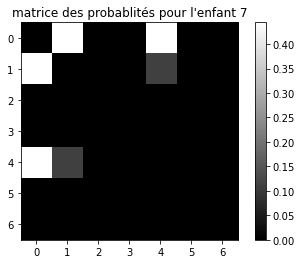

In [9]:
def Matrix_Proba(E):
    Matrix = np.zeros((n,n)) #initialise la matrice des probas
    for i in range(n):
        for j in range(i,n):
            Matrix[i,j] = Proba_Par_Enf(i+1,j+1,E) #i+1 et j+1 car on est avec python
            Matrix[j,i] = Matrix[i,j]
            #Donne la probabilité de donner E grâce aux parents i+1 et j+1
    return Matrix/(Matrix.sum()/2)
            
plt.imshow(Matrix_Proba(7),cmap='gray')
plt.colorbar()
plt.title("matrice des probablités pour l'enfant 7")

### Fonction 5

In [10]:
#Retrouver les indices des parents qui sont les plus probables

def Recup_Parents_max(E): #E est un enfant
    M = Matrix_Proba(E) #Matrice des probas
    P1,P2 = np.unravel_index(np.argmax(M),M.shape)
    # np.argmax(M) --> donne l'argmax de la matrice applatie
    #np.unravel_index(np.argmax(M),M.shape) --> récupère l'indice (i,j)
    return [E,P1+1,P2+1,-np.log(M.max())] # /!\ P1+1 et P2+1 

Liste_pedigree = [] 
for e in range(gen,n+1):
    Liste_pedigree.append(Recup_Parents_max(e))

Liste_pedigree



[[5, 1, 2, -0.0], [6, 2, 4, -0.0], [7, 1, 2, 0.8109302162163288]]

In [11]:
## Exemple sur une matrice 3x3
#pour retrouver le bon indice

M = np.array([[1,2,3],[4,10,6],[7,7,9]])
np.unravel_index(np.argmax(M),M.shape)

(1, 1)

# Représentation graphique avec igraph

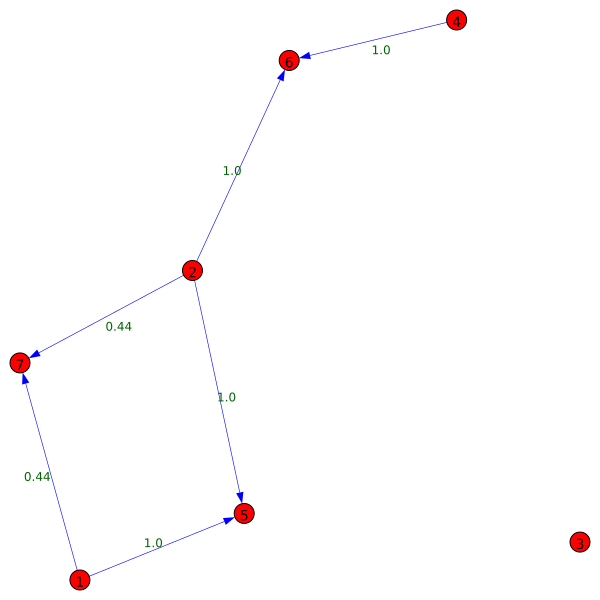

In [12]:

# Créez un graphe non orienté vide
g = ig.Graph(directed = True)

# Spécifiez un nom pour chaque nœud
node_names = [f'{i+1}' for i in range(n) ]

# Ajoutez n noeuds à l'arbre
g.add_vertices(len(node_names)) 


# Ajoutez des arêtes pour connecter les noeuds et former un arbre
for i in range(len(Liste_pedigree)):
    E,P1,P2 = Liste_pedigree[i][0]-1, Liste_pedigree[i][1]-1,Liste_pedigree[i][2] -1
    # /!\ Avec Python on commence à compter à 0 E,P1 et P2 sont des indices
      # Définissez les options de l'arête, par exemple, la couleur
        
    edge_options = {
            "color": "blue",     # Couleur de l'arête (par exemple, "blue", "red", "green")
            "width": 0.6,          # Largeur de l'arête
            "arrow_size": 0.8,    # Taille de la flèche de l'arête (pour les graphes dirigés)
            "label": round(np.exp(-Liste_pedigree[i][3]),2),    # Étiquette de l'arête
            "label_color": "#006400",  # Couleur de l'étiquette
            "label_dist": 0.4,   # Distance de l'étiquette par rapport à l'arête
            "label_font_size": 8,  # Taille de la police de l'étiquette
            "curve": 1,      # Courbure de l'arête (pour les graphes dirigés)
            }
    g.add_edges([(P1, E),(P2,E)],edge_options) 
    # Par exemple, pour créer deux branche avec les flèches qui vont bien 
    
    
ig.plot(g,vertex_label=node_names)#, bbox=(350,500))







